# Dependencies

In [9]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [10]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [11]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [12]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
cv2.setRNGSeed(seed)

# Fetch from TfRecords

In [13]:
PATH_KAGGLE_DS = "kaggle_dataset"
dataset_df = pd.read_csv(os.path.join(PATH_KAGGLE_DS, "train.csv"))
PATH_TFRECORD_DS = os.path.join(PATH_KAGGLE_DS, "train_tfrecords")
tf_records = dataset_df.file_id.map(lambda x: os.path.join(PATH_TFRECORD_DS, f"{x}.tfrecord")).unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [14]:
with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'r') as f:
    json_str = f.read()
FEATURE_COLUMNS = json.loads(json_str)
FEATURE_COLUMNS[:10]

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9']

In [15]:
# These points represent the hands, elbows, and shoulders.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]

# Facial information isn't necessary, but the nose will serve as a midpoint for normalizing the data, as it is usually located in the middle of the frame.
FPOSE = [0] # Nose as midpoint

# Collecting the indices of certain important/distinct sets of features.
# This can be beneficial during the preprocessing step.
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 0] # Nose

In [16]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [17]:
# The default mapping that came with the dataset was changed:
# padding is represented with the number 0
# start_token is 60
# end_token is 61
with open (os.path.join(PATH_KAGGLE_DS, "character_to_prediction_index.json"), "r") as f:
    char_to_num = json.load(f)
    
char_to_num = {c:char_to_num[c]+1 for c in char_to_num}

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
pad_token_idx = 0
char_to_num[pad_token] = pad_token_idx

start_token = '<'
start_token_idx = 60
char_to_num[start_token] = start_token_idx

end_token = '>'
end_token_idx = 61
char_to_num[end_token] = end_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}

## Preprocess phrase

In [18]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="tf_char_to_num"
)

# Function to decode the characters and pad the phrases
MAX_PHRASE_LEN = 31 + 2 # The start and end token take space as well
def preprocess_phrase(phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]

    return phrase

## Preprocess landmark A

In [19]:
FRAME_LEN = 256
def preprocess_landmark_a(x):
    # Select distinct groups
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    # Calculate how many unknown values there are for each hand
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # As fingerspelling gestures only use one hand, the model will only receive the dominant one. (=less NaN values)
    # Also from the pose information, only the dominant side is needed.
    is_right_hand = True
    hand = rhand
    pose = rpose
    num_of_hand_lm = len(RHAND_IDX)
    num_of_pose_lm = len(RPOSE_IDX)
    if rnans > lnans:
        is_right_hand = False
        hand = lhand
        pose = lpose
        num_of_hand_lm = len(LHAND_IDX)
        num_of_pose_lm = len(LPOSE_IDX)
    
    # Gather channels
    hand_x = hand[:, 0*(num_of_hand_lm//3) : 1*(num_of_hand_lm//3)]
    hand_y = hand[:, 1*(num_of_hand_lm//3) : 2*(num_of_hand_lm//3)]
    hand_z = hand[:, 2*(num_of_hand_lm//3) : 3*(num_of_hand_lm//3)]
    
    # Flip the x axis if it's the left hand. (This makes it resemble the right hand more.)
    if not is_right_hand:
        hand_x = 1 - hand_x
    
    # Join along a new axis
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1) # (SEQ_LEN, LM_COUNT, 3)
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :] # Mean and std along the first axis (across LM_COUNT)
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std
    
    # The same for pose
    pose_x = pose[:, 0*(num_of_pose_lm//3) : 1*(num_of_pose_lm//3)]
    pose_y = pose[:, 1*(num_of_pose_lm//3) : 2*(num_of_pose_lm//3)]
    pose_z = pose[:, 2*(num_of_pose_lm//3) : 3*(num_of_pose_lm//3)]
    
    if not is_right_hand:
        pose_x = 1 - pose_x
    
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    mean = tf.math.reduce_mean(pose, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(pose, axis=1)[:, tf.newaxis, :]
    pose = (pose - mean) / std
    
    # Join the data
    x = tf.concat([hand, pose], axis=1)
    
    # Replace NaN with 0.
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    
    # x.shape == (FRAME_LEN, FEATURE_COUNT, 3)
    
    # Reshape to (FRAME_LEN, FEATURE_COUNT*3 == num_of_hand_lm + num_of_pose_lm)
    x = tf.reshape(x, (FRAME_LEN, num_of_hand_lm + num_of_pose_lm))
    
    return x

## Preprocess landmark B

In [12]:
FRAME_LEN = 256

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))
   
def preprocess_landmark_b(x):
    # Select distinct groups
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    nose = tf.gather(x, MID_POINT_IDX, axis=1)
    
    # Calculate how many unknown values there are for each hand
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # As fingerspelling gestures only use one hand, the model will only receive the dominant one. (=less NaN values)
    # Also from the pose information, only the dominant side is needed.
    is_right_hand = True
    hand = rhand
    pose = rpose
    num_of_hand_lm = len(RHAND_IDX)
    num_of_pose_lm = len(RPOSE_IDX)
    if rnans > lnans:
        is_right_hand = False
        hand = lhand
        pose = lpose
        num_of_hand_lm = len(LHAND_IDX)
        num_of_pose_lm = len(LPOSE_IDX)
    
    # Gather channels
    hand_x = hand[:, 0*(num_of_hand_lm//3) : 1*(num_of_hand_lm//3)]
    hand_y = hand[:, 1*(num_of_hand_lm//3) : 2*(num_of_hand_lm//3)]
    hand_z = hand[:, 2*(num_of_hand_lm//3) : 3*(num_of_hand_lm//3)]
    pose_x = pose[:, 0*(num_of_pose_lm//3) : 1*(num_of_pose_lm//3)]
    pose_y = pose[:, 1*(num_of_pose_lm//3) : 2*(num_of_pose_lm//3)]
    pose_z = pose[:, 2*(num_of_pose_lm//3) : 3*(num_of_pose_lm//3)]
    nose_x = nose[:, 0 : 1]
    nose_y = nose[:, 1 : 2]
    nose_z = nose[:, 2 : 3]
    # Combine all x, y, z coordinates
    combined_x = tf.concat([nose_x, hand_x, pose_x], axis=-1)
    combined_y = tf.concat([nose_y, hand_y, pose_y], axis=-1)
    combined_z = tf.concat([nose_z, hand_z, pose_z], axis=-1)
    
    # Flip the x axis if it's the left hand. (This makes it resemble the right hand more.)
    if not is_right_hand:
        hand_x = 1 - hand_x
    # Join along a new axis
    x = tf.concat([combined_x[..., tf.newaxis], combined_y[..., tf.newaxis], combined_z[..., tf.newaxis]], axis=-1) # (SEQ_LEN, LM_COUNT, 3)
    # x.shape == (T, P, C)
    # N: Batch size -> 1 for now
    # T: Sequence length
    # P: Number of points (or landmarks)
    # C: Number of channels (features) per point
    
    x = x[None,...] # x.shape == (1, T, P, C)
    
    # Mean of midpoints (nose) through timesteps
    mean = tf_nan_mean(tf.gather(x, [0], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
    # x.shape == (N, 1, 1, C)
    
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    # std.shape == (N, 1, 1, C)
    
    x = (x - mean)/std
    # x.shape == (N, T, P, C)

    # Limit seq_len
    x = x[:,:FRAME_LEN]
    seq_length = tf.shape(x)[1]
    x = x[...,:2]
    # x.shape == (N, T, P, 2)

    # Calc differences between consequtive frames and with skipping 1 in between
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    # dx.shape == (N, T, P, 2)
    
    x = tf.concat([
        tf.reshape(x, (-1,seq_length,2*tf.shape(x)[2])),
        tf.reshape(dx, (-1,seq_length,2*tf.shape(dx)[2])),
    ], axis = -1)
    # x.shape == (N, T, features) where T <= FRAME_LEN
    
    # Replace NaN values with zeros
    x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

    x = x[0] # x.shape == (T, features)
    
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, [[0, FRAME_LEN-tf.shape(x)[0]], [0, 0]])

    # x.shape == (FRAME_LEN, features)
    
    return x

## Combined preprocessing for lm and phrase

In [20]:
def preprocess(landmark, phrase):
    phrase = preprocess_phrase(phrase)
    return (preprocess_landmark_a(landmark), phrase[:-1]), phrase[1:] # Shifted phrase for encoder-decoder architecture

## Create TFDataset

In [21]:
batch_size = 32
train_len = int(0.8 * len(tf_records))

def get_dataset(tfrecords, batch_size=1, repeat=False, shuffle=False, drop_remainder=False, cache=False):
    ds = tf.data.TFRecordDataset(tf_records)
    ds = ds.map(decode_fn, tf.data.AUTOTUNE)
    # Note: preprocessing can happen before and after the batching (if you can preprocess the whole batch at once to save computation time)
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size > 1:
        # There's also a padded_batch version of this function
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # If the system doesn't have enough RAM caching might slow down the process
    if cache:
        ds = ds.cache()
    
    return ds

train_ds = get_dataset(tf_records[:train_len], batch_size=batch_size, cache=True)
valid_ds = get_dataset(tf_records[train_len:], batch_size=batch_size, cache=True)

In [22]:
lm_shape = None
phrase_shape = None

# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)

# Print data points from the training dataset
print("Training Data:\n")
(landmarks, context), phrase = next(train_iterator)

# Save shapes
lm_shape = landmarks.shape[2]
phrase_shape = phrase.shape[0]
print("Saved shapes:")
print(f"lm_shape: {lm_shape}")
print(f"phrase_shape: {phrase_shape}")
print("-" * 40)
print()

print("Encoder input - first in batch (Landmarks:)")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0])
print("-" * 40)
print()

print("Decoder input (Context):")
print(context.shape)
print(context[0])
print("-" * 40)
print()

print("Model target output (Phrase):")
print(phrase.shape)
print(phrase[0])
print("-" * 40)

Training Data:

Saved shapes:
lm_shape: 78
phrase_shape: 32
----------------------------------------

Encoder input - first in batch (Landmarks:)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 78)
tf.Tensor(
[[-0.27655613  1.5076838   2.3224409  ...  0.86484635 -0.640369
  -0.31775153]
 [ 0.          0.          0.         ...  0.9932173  -0.4573373
  -0.3150256 ]
 [ 0.          0.          0.         ...  0.8487494  -0.6870108
  -0.31365472]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(256, 78), dtype=float32)
----------------------------------------

Decoder input (Context):
(32, 33)
tf.Tensor(
[60 19  1 35 50 37 37 43 40 47 53 51 37 61  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0], shape=(33,), dtype=int32)
----------------------------------------

Model target output 

# Model creation

## Common elements

In [23]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalTokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_future_input_size):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=max_future_input_size, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class LandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        
    def call(self, x):
        x = self.conv_block(x)
        return x

class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        
    def call(self, x):
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x

## Encoder-Decoder using recurrent units

In [46]:
class Seq2SeqRecurrent(tf.keras.Model):
    def __init__(self, *, recurrent_unit_type, num_recurrent_layers=1, len_lm_seq, num_conv_layers, filter_size, d_model, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
        super().__init__()

        if recurrent_unit_type not in ['LSTM', 'SimpleRNN', 'GRU']:
            raise ValueError(f"Invalid recurrent_unit_type: {recurrent_unit_type}. Choose from ['LSTM', 'SimpleRNN', 'GRU']")

        self.max_future_input_size = max_future_input_size

        # Positional embeddings and dropout
        self.enc_pos_embedding = LandmarkEmbedding(len_lm_seq, d_model, num_conv_layers, filter_size)
        self.enc_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_pos_embedding = PositionalTokenEmbedding(vocab_size=input_vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
        self.dec_dropout = tf.keras.layers.Dropout(dropout_rate)

        # Encoder recurrent units
        recurrent_unit = {'LSTM': tf.keras.layers.LSTM, 'SimpleRNN': tf.keras.layers.SimpleRNN, 'GRU': tf.keras.layers.GRU}[recurrent_unit_type]
        self.enc_recurrent_layers = [recurrent_unit(d_model, return_sequences=True, return_state=True) for _ in range(num_recurrent_layers)]
        self.dec_recurrent_layers = [recurrent_unit(d_model, return_sequences=True, return_state=True) for _ in range(num_recurrent_layers)]

        # Final classifier
        self.classifier = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        landmark_seq, prev_gen_ctx  = inputs

        encoded_lm_seq = self.enc_pos_embedding(landmark_seq)
        encoded_lm_seq = self.enc_dropout(encoded_lm_seq)

        states = None
        for layer in self.enc_recurrent_layers:
            encoded_lm_seq, *states = layer(encoded_lm_seq, initial_state=states)

        # states now contain the final state(s) of the encoder
        embedded_ctx = self.dec_pos_embedding(prev_gen_ctx)
        embedded_ctx = self.dec_dropout(embedded_ctx)

        mask = self.dec_pos_embedding.compute_mask(prev_gen_ctx)
        # Initialize the first decoder layer with the final state of the encoder
        embedded_ctx, *_ = self.dec_recurrent_layers[0](embedded_ctx, initial_state=states, mask=mask)

        for layer in self.dec_recurrent_layers[1:]:
            embedded_ctx, *_ = layer(embedded_ctx, mask=mask)

        logits = self.classifier(embedded_ctx)

        try:
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

# This function is important in case the model needs to be loaded only from the saved weights.
# The exact model needs to be recreated, with all parameters matching!
def get_model(d_model):
    max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on
    
    seq2seq_model = Seq2SeqRecurrent(
        recurrent_unit_type="LSTM", # LSTM, SimpleRNN, GRU
        num_recurrent_layers=1,
        len_lm_seq=FRAME_LEN,
        num_conv_layers=3,
        filter_size=11,
        d_model=d_model,
        input_vocab_size=len(char_to_num),
        target_vocab_size=len(char_to_num),
        max_future_input_size=max_future_input_size,
        dropout_rate=0.1)

    return seq2seq_model

D_MODEL = 256 # embedding size

model = get_model(D_MODEL)

## General transformer

Source: https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=1Rz82wEs5biZ

In [68]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)
       
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
    
        x = self.add([x, attn_output])
        x = self.layernorm(x)
    
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, len_of_seq, num_layers, d_model, num_heads,
               dff, num_conv_layers, filter_size, dropout_rate=0.1):
        super().__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = LandmarkEmbedding(
            len_of_seq, d_model, num_conv_layers, filter_size)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is landmark sequences with shape: (batch, seq_len, features)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
    
        return x  # Shape `(batch_size, seq_len, d_model)`.
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
    
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
    
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
    
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, max_future_input_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalTokenEmbedding(vocab_size=vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]
    
        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
    
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x
    
class GeneralTransformer(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_enc_layers, num_conv_layers, filter_size, num_dec_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
        super().__init__()
        self.max_future_input_size = max_future_input_size
        
        self.encoder = Encoder(len_of_seq=len_lm_seq,
                               num_layers=num_enc_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               num_conv_layers=num_conv_layers,
                               filter_size=filter_size,
                               dropout_rate=dropout_rate)
        
        self.decoder = Decoder(num_layers=num_dec_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               max_future_input_size=max_future_input_size,
                               dropout_rate=dropout_rate)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        landmark_seq, prev_gen_context  = inputs
    
        encoded_lm_seq = self.encoder(landmark_seq)  # (batch_size, landmark_seq_len, d_model)
        x = self.decoder(prev_gen_context, encoded_lm_seq)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

# This function is important in case the model needs to be loaded only from the saved weights.
# The exact model needs to be recreated, with all parameters matching!
def get_model(d_model):
    max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on
    
    general_transformer = GeneralTransformer(
        len_lm_seq=FRAME_LEN,
        num_enc_layers=2,
        num_conv_layers=3,
        filter_size=11,
        num_dec_layers=4,
        d_model=d_model,
        num_heads=2,
        dff=256, 
        input_vocab_size=len(char_to_num),
        target_vocab_size=len(char_to_num),
        max_future_input_size=max_future_input_size,
        dropout_rate=0.1)

    return general_transformer

D_MODEL = 256 # embedding size

model = get_model(D_MODEL)

## Initialize weights

In [56]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

model.summary()

(32, 256, 78)
(32, 33)
(32, 33, 62)
Model: "general_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4031232   
                                                                 
 decoder (Decoder)           multiple                  2252800   
                                                                 
 dense_12 (Dense)            multiple                  15934     
                                                                 
Total params: 6299966 (24.03 MB)
Trainable params: 6299966 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

### Parameters

In [81]:
epochs = 30

### Learning rate

#### Linear warm-up inverse square root decay

The learning rate formula used in the "Attention Is All You Need" paper, where the Transformer architecture was introduced. This learning rate schedule is often referred to as the Transformer learning rate schedule or the Noam learning rate schedule (after one of the paper's authors, Noam Shazeer).

The schedule first increases the learning rate linearly for warmup_steps steps, and then decreases it proportionally to the inverse square root of the step count. The rate at which it decreases is modulated by the model's depth (d_model). This combination ensures a rapid increase at the beginning of training, allowing the model to learn quickly, and then a gradual decrease to fine-tune as training progresses.

In the context of the Transformer architecture, this learning rate schedule was found to be effective. The warm-up steps help stabilize training early on, while the decay helps in convergence in the later stages of training.

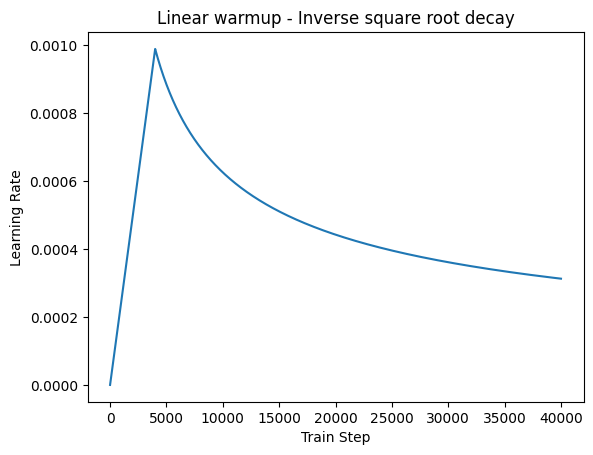

In [84]:
class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.sqrt_d_model = tf.math.rsqrt(tf.cast(d_model, tf.float32))
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return self.sqrt_d_model * tf.math.minimum(arg1, arg2)

transformer_schedule = TransformerSchedule(D_MODEL)

plt.plot(transformer_schedule(tf.range(40000, dtype=tf.float32)))
plt.title("Linear warmup - Inverse square root decay")
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.savefig('Linear warmup - Inverse square root decay.png', dpi=300)  # High resolution
plt.show()

#### Linear warm-up cosine decay

For the Seq2Seq model, especially when trained on tasks like neural machine translation or any other sequence generation tasks, a combination of warm-up followed by a cosine or polynomial decay often works well.

In [82]:
# This is not the ideal way to do this, but it's managable with the size of the dataset
steps_per_epoch = sum(1 for _ in train_ds)

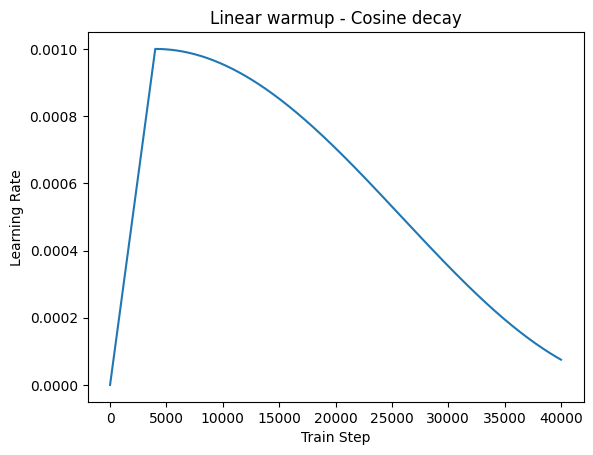

In [83]:
class WarmupCosineDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, warmup_steps, total_steps):
        super().__init__()
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        
        # Linear Warm-up
        warmup_lr = self.max_lr * (step / self.warmup_steps)
        
        # Cosine Decay (excluding the warm-up phase)
        decay_steps = tf.maximum(step - self.warmup_steps, 0)
        remaining_steps = self.total_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.math.cos(np.pi * decay_steps / remaining_steps))
        decayed_lr = self.max_lr * cosine_decay
        
        return tf.where(step < self.warmup_steps, warmup_lr, decayed_lr)

# Example usage
max_lr = 0.001
warmup_steps = 4000
total_steps = steps_per_epoch * epochs
seq2seq_schedule = WarmupCosineDecaySchedule(max_lr, warmup_steps, total_steps)

plt.plot(seq2seq_schedule(tf.range(40000, dtype=tf.float32)))
plt.title("Linear warmup - Cosine decay")
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.savefig('Linear warmup - Cosine decay.png', dpi=300)  # High resolution
plt.show()

#### Optimizer

In [305]:
optimizer = tf.keras.optimizers.Adam(seq2seq_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

#### Metrics

In [306]:
def masked_loss(label, pred):
    mask = label != pad_token_idx
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != pad_token_idx

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [307]:
model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [308]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{model.name}_weights_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [309]:
%%time
model.fit(train_ds,
                validation_data=valid_ds,
                epochs=epochs,
                callbacks=[model_checkpoint_callback],
                verbose = 2)

Epoch 1/30

Epoch 1: val_loss improved from inf to 2.16953, saving model to seq2_seq_recurrent_3_weights_checkpoint.h5
1591/1591 - 1603s - loss: 2.6940 - masked_accuracy: 0.2387 - val_loss: 2.1695 - val_masked_accuracy: 0.3466 - 1603s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_loss improved from 2.16953 to 1.85601, saving model to seq2_seq_recurrent_3_weights_checkpoint.h5
1591/1591 - 1515s - loss: 2.0235 - masked_accuracy: 0.3937 - val_loss: 1.8560 - val_masked_accuracy: 0.4448 - 1515s/epoch - 952ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.85601 to 1.66784, saving model to seq2_seq_recurrent_3_weights_checkpoint.h5
1591/1591 - 1562s - loss: 1.7887 - masked_accuracy: 0.4668 - val_loss: 1.6678 - val_masked_accuracy: 0.5017 - 1562s/epoch - 982ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.66784 to 1.49657, saving model to seq2_seq_recurrent_3_weights_checkpoint.h5
1591/1591 - 1558s - loss: 1.6054 - masked_accuracy: 0.5228 - val_loss: 1.4966 - val_masked_accuracy: 0.5528 - 

KeyboardInterrupt: 

In [311]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = model((test_inp, test_ctx))
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
num_to_char[pred_idx]

'c'

# Save model

In [26]:
tf_chars = tf.constant(list(char_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(char_to_num.values()), dtype=tf.int64)

class EncoderDecoderModelWrapper(tf.Module):
    def __init__(self, model):
        super(EncoderDecoderModelWrapper, self).__init__()
        self.model = model
        self.save_name = self.model.name
        
        self.tf_char_to_num = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_chars,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_char_to_num_lut"
        )
        
        self.tf_num_to_char = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_nums,
                values=tf_chars,
            ),
            default_value=tf.constant("unknown", dtype=tf.string),
            name="tf_num_to_char_lut"
        )

        self.ctx_len = tf.constant(self.model.max_future_input_size, dtype=tf.int32)

    @tf.function()
    def info(self):
        return tf.constant(FEATURE_COLUMNS)

    # @tf.function(input_signature=[
    #     tf.TensorSpec(shape=[tf.constant(FRAME_LEN), tf.constant(lm_shape)], dtype=tf.float32),
    #     tf.TensorSpec(shape=[], dtype=tf.string), # The input string is trimmed to max size set when initializing model
    # ])
    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, tf.constant(len(FEATURE_COLUMNS))], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.string), # The input string is trimmed to max size set when initializing model
    ])
    def predict(self, landmarks, ctx):
        # Prepare input
        # Trim context to not exceed max size
        ctx_length = tf.strings.length(ctx)
        starting_pos = tf.maximum(ctx_length - self.ctx_len, 0)
        ctx = tf.strings.substr(ctx, starting_pos, self.ctx_len)

        ctx_chars = tf.strings.unicode_split(ctx, input_encoding='UTF-8')
        ctx_tokens = self.tf_char_to_num.lookup(ctx_chars)
        batched_ctx_tokens = tf.expand_dims(ctx_tokens, axis=0) # Adds first ("batch") dimension to the tensor

        landmarks = preprocess_landmark_a(landmarks)
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model((batched_landmarks, batched_ctx_tokens), training=False)
        logits = logits[:, -1:, :][0][0] # Select the last element in the middle dimension (the first is the batch dim, the last is the num_of_classes dim)
        
        # Parse result
        probabilities = tf.nn.softmax(logits)
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_char = self.tf_num_to_char.lookup(pred_idx)
        
        return {'result' : pred_char, 'confidence': pred_prob}

In [329]:
wrapped_model = EncoderDecoderModelWrapper(model)

In [330]:
%%time
wrapped_model.predict(np.zeros((FRAME_LEN, len(FEATURE_COLUMNS))), "abc")

CPU times: total: 1.45 s
Wall time: 1.26 s


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'h'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.55950594>}

Note: first time execution is usually slower than the rest.

In [331]:
save_model_name = wrapped_model.save_name
if os.path.isdir(save_model_name):
    print(f"A model with the same name ({save_model_name}) has already been saved!")
else:
    tf.saved_model.save(wrapped_model, export_dir=save_model_name)
    print(f"A model with the name ({save_model_name}) was just saved!")

INFO:tensorflow:Assets written to: seq2_seq_recurrent_3\assets


INFO:tensorflow:Assets written to: seq2_seq_recurrent_3\assets


A model with the name (seq2_seq_recurrent_3) was just saved!


# Load model

## From saved weights

1. Create model object with same parameters
2. Build the model (run inference on it, to initialize the parameters)
3. Load the weights
4. Convert it to tf.Module or run manual inference on it

In [69]:
new_model = get_model(D_MODEL)

In [70]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = new_model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

new_model.summary()

(32, 256, 78)
(32, 33)
(32, 33, 62)
Model: "general_transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  2979584   
                                                                 
 decoder_5 (Decoder)         multiple                  4756992   
                                                                 
 dense_71 (Dense)            multiple                  15934     
                                                                 
Total params: 7752510 (29.57 MB)
Trainable params: 7752510 (29.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
new_model.load_weights("general_transformer_no_pos_embed/general_transformer_3_noposembed_60epochs_weights_checkpoint.h5")

In [72]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = new_model((test_inp, test_ctx), training=False)
logits = logits[:, -1:, :][0][0]
pred_idx = np.argmax(tf.nn.softmax(logits))
num_to_char[pred_idx]

'l'

In [73]:
loaded_model = EncoderDecoderModelWrapper(new_model)

In [75]:
loaded_model.predict(np.zeros((FRAME_LEN, len(FEATURE_COLUMNS))), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'l'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.14071961>}

In [76]:
save_model_name = "transformer_seq2seq"
if os.path.isdir(save_model_name):
    print(f"A model with the same name ({save_model_name}) has already been saved!")
else:
    tf.saved_model.save(loaded_model, export_dir=save_model_name)
    print(f"A model with the name ({save_model_name}) was just saved!")

INFO:tensorflow:Assets written to: transformer_seq2seq\assets


INFO:tensorflow:Assets written to: transformer_seq2seq\assets


A model with the name (transformer_seq2seq) was just saved!


## From saved model

In [235]:
loaded_model = tf.saved_model.load("saved_model")

In [236]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'_'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.02006547>}